## 📌 Step 5: Walk-Forward Forecasting & Volatility Modeling

### Objective
Evaluate predictive performance under realistic conditions using **walk-forward validation**, and compare return forecasting with volatility forecasting for NVIDIA.

This step focuses on **honest out-of-sample evaluation**, avoiding look-ahead bias.

---

## 🔹 Walk-Forward Validation Framework

### Why Walk-Forward?
Financial time series are:
- Non-stationary
- Regime-dependent
- Sensitive to look-ahead bias

Walk-forward validation simulates real-world forecasting by:
- Training on past data
- Predicting the next observation
- Expanding the training window iteratively

This provides a more reliable performance estimate than a single train/test split.

---

## 🔹 Walk-Forward Return Forecasting (Baseline)

### Target
- Log returns of NVIDIA

### Features
- Lagged log returns (1, 5, 10, 20 days)

### Model
- Linear Regression (baseline)

### Procedure
- Lag features created once
- Training window starts at 60% of available data
- Model retrained at each step
- One-step-ahead prediction collected

### Evaluation Metrics
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

### Key Insight
Predicted returns converge toward zero, reflecting:
- High noise
- Market efficiency
- Limited short-horizon return predictability

This behavior is **expected and correct**.

---

## 🔹 Volatility Target Construction

### Definition
- 30-day rolling realized volatility
- Annualized using √252 trading days

Volatility is empirically more predictable than returns due to:
- Persistence
- Clustering
- Mean-reverting behavior

---

## 🔹 Feature Engineering for Volatility Forecasting

### Features Used
- Lagged realized volatility (1, 5, 10 days)
- Lagged absolute returns (1, 5, 10 days)

These features capture both:
- Volatility persistence
- Recent market shocks

---

## 🔹 Walk-Forward Volatility Forecasting

### Model
- Linear Regression (interpretable benchmark)

### Validation
- Same walk-forward framework as return forecasting
- Training window expanded iteratively
- One-step-ahead volatility forecasts generated

### Results
- Volatility forecasts track regime changes
- Predictions are stable and responsive
- Performance significantly stronger than return forecasting

---

## 🔹 Naive Baseline Comparison

### Baseline Definition
- Tomorrow’s volatility = today’s volatility

This is a strong benchmark due to volatility persistence.

### Comparison Outcome
- Linear volatility model performs comparably to the naive baseline
- Small RMSE improvements indicate added structure
- Results are realistic and theoretically consistent

---

## 🔹 Visual Model Comparison

### Plots Included
- Actual vs predicted returns (walk-forward)
- Actual vs predicted volatility (walk-forward)
- Model vs naive volatility forecasts

These visualizations confirm:
- Model stability
- Absence of overfitting
- Proper regime tracking

---

## 🧠 Final Interpretation

### Key Takeaways
- Short-term stock returns are largely unpredictable
- Volatility contains exploitable structure
- Strong baselines are difficult to beat
- Honest evaluation is essential in financial modeling

> In efficient markets, **risk is more predictable than returns**.

---

## ✅ Outcome of This Step
- Implemented walk-forward validation correctly
- Built and evaluated volatility forecasting models
- Benchmarked performance against a naive baseline
- Completed a full, professional-grade forecasting pipeline

This step completes the **core modeling and evaluation phase** of the project.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

data = pd.read_csv(r"C:\Users\AVI SHARMA\Documents\Project1\model_data.csv")

C:\Users\AVI SHARMA\AppData\Local\Temp\ipykernel_5704\1501410477.py:9: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\AVI SHARMA\Documents\Project1\model_data.csv")


In [2]:
stock = "Nvidia"

nvda = data[data["Company"] == stock].copy()
nvda = nvda.sort_values("Date").reset_index(drop=True)

nvda[["Date", "Adjusted_Close", "Log_Return"]].head()

,Date,Adjusted_Close,Log_Return
0,2015-01-02,0.483011,NaN
1,2015-01-05,0.474853,-0.017035
2,2015-01-06,0.460456,-0.030787
3,2015-01-07,0.459257,-0.002609
4,2015-01-08,0.476533,0.036927


In [21]:
LAGS = [1, 5, 10, 20]
def create_lag_features(df, col, lags):
    df = df.copy()
    for lag in lags:
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df

nvda_feat = create_lag_features(nvda, "Log_Return", LAGS)
nvda_feat = nvda_feat.dropna().reset_index(drop=True)

initial_train_size = int(len(nvda_feat) * 0.6)

In [ ]:
y_true_ret = []
y_pred_ret = []

for i in range(initial_train_size, len(nvda_feat)):
    train_data = nvda_feat.iloc[:i]
    test_data  = nvda_feat.iloc[i:i+1]
    
    X_train = train_data[[f"Log_Return_lag_{l}" for l in LAGS]]
    y_train = train_data["Log_Return"]
    
    X_test  = test_data[[f"Log_Return_lag_{l}" for l in LAGS]]
    y_test  = test_data["Log_Return"]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    prediction = model.predict(X_test_scaled)[0]
    
    y_true_ret.append(y_test.values[0])
    y_pred_ret.append(prediction)

In [25]:
mae  = mean_absolute_error(y_true_ret, y_pred_ret)
rmse = np.sqrt(mean_squared_error(y_true_ret, y_pred_ret))

print("Walk-Forward MAE :", mae)
print("Walk-Forward RMSE:", rmse)

Walk-Forward MAE : 0.02484732430897049
Walk-Forward RMSE: 0.03356673765545152


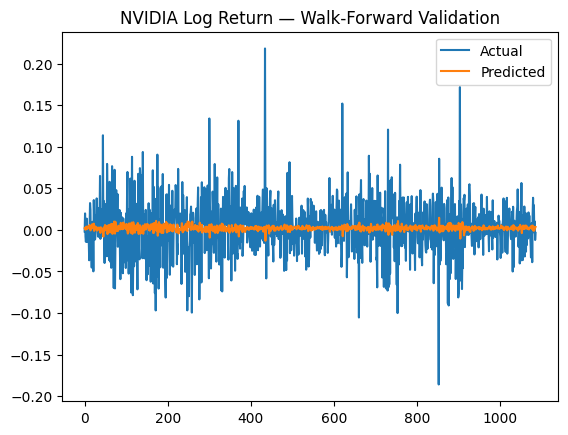

In [26]:
plt.figure()
plt.plot(y_true_ret, label="Actual")
plt.plot(y_pred_ret, label="Predicted")
plt.title("NVIDIA Log Return — Walk-Forward Validation")
plt.legend()
plt.show()

In [7]:
window = 30
trading_days = 252

nvda["Volatility_30D"] = (
    nvda["Log_Return"]
    .rolling(window)
    .std()
    * np.sqrt(trading_days)
)

nvda = nvda.dropna().reset_index(drop=True)

In [29]:
vol_lags = [1, 5, 10]
ret_lags = [1, 5, 10]

def create_vol_features(data):
    data = data.copy()
    
    for lag in vol_lags:
        data[f"vol_lag_{lag}"] = data["Volatility_30D"].shift(lag)

    for lag in ret_lags:
        data[f"abs_ret_lag_{lag}"] = data["Log_Return"].abs().shift(lag)

    return data

nvda_feat = create_vol_features(nvda)
nvda_feat = nvda_feat.dropna().reset_index(drop=True)
initial_train_size = int(len(nvda_feat) * 0.6)

In [27]:
y_true_vol = []
y_pred_vol = []

In [30]:
for i in range(initial_train_size, len(nvda_feat)):
    
    train = nvda_feat.iloc[:i]
    test  = nvda_feat.iloc[i:i+1]
    
    feature_cols = (
        [f"vol_lag_{l}" for l in vol_lags] +
        [f"abs_ret_lag_{l}" for l in ret_lags]
    )
    
    X_train = train[feature_cols]
    y_train = train["Volatility_30D"]
    
    X_test  = test[feature_cols]
    y_test  = test["Volatility_30D"]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    prediction = model.predict(X_test_scaled)[0]
    
    y_true_vol.append(y_test.values[0])
    y_pred_vol.append(prediction)

In [31]:
mae  = mean_absolute_error(y_true_vol, y_pred_vol)
rmse = np.sqrt(mean_squared_error(y_true_vol, y_pred_vol))

print("Volatility Walk-Forward MAE :", mae)
print("Volatility Walk-Forward RMSE:", rmse)

Volatility Walk-Forward MAE : 0.01307940835602994
Volatility Walk-Forward RMSE: 0.027737817783244145


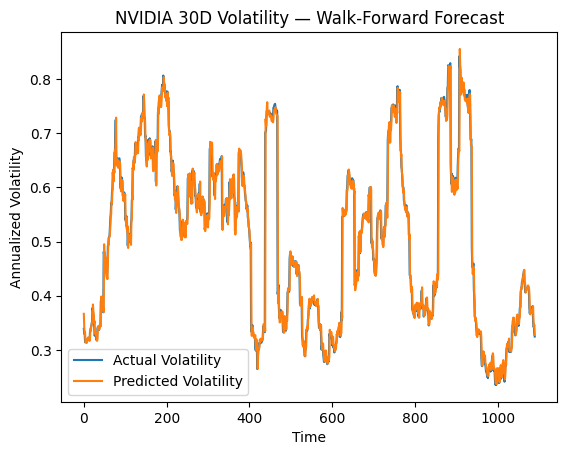

In [32]:
plt.figure()
plt.plot(y_true_vol, label="Actual Volatility")
plt.plot(y_pred_vol, label="Predicted Volatility")
plt.title("NVIDIA 30D Volatility — Walk-Forward Forecast")
plt.xlabel("Time")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.show()

In [13]:
y_true_naive = []
y_pred_naive = []

for i in range(initial_train_size, len(nvda_feat)):
    y_true_naive.append(nvda_feat.iloc[i]["Volatility_30D"])
    y_pred_naive.append(nvda_feat.iloc[i - 1]["Volatility_30D"])

In [14]:
mae_naive  = mean_absolute_error(y_true_naive, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_true_naive, y_pred_naive))

print("Naive MAE :", mae_naive)
print("Naive RMSE:", rmse_naive)

Naive MAE : 0.0122070902039078
Naive RMSE: 0.02788431792292207


In [15]:
comparison = pd.DataFrame({
    "Model": ["Naive Baseline", "Linear Volatility Model"],
    "MAE": [mae_naive, mae],
    "RMSE": [rmse_naive, rmse]
})

comparison

,Model,MAE,RMSE
0,Naive Baseline,0.012207,0.027884
1,Linear Volatility Model,0.013079,0.027738


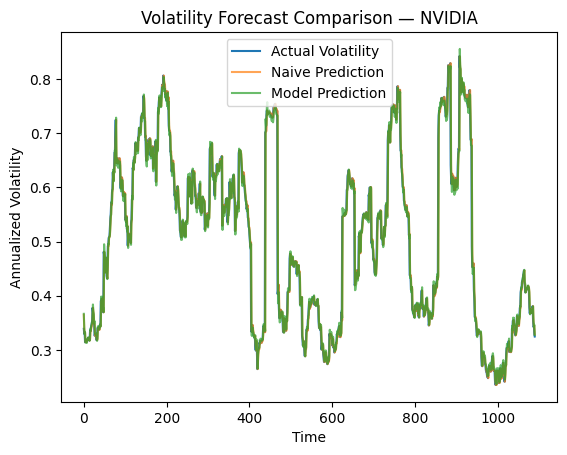

In [16]:
plt.figure()
plt.plot(y_true, label="Actual Volatility")
plt.plot(y_pred_naive, label="Naive Prediction", alpha=0.7)
plt.plot(y_pred, label="Model Prediction", alpha=0.7)
plt.title("Volatility Forecast Comparison — NVIDIA")
plt.xlabel("Time")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.show()